<a href="https://colab.research.google.com/github/PseudoKush/Traffic-Sign-Classification/blob/master/traffic_sign_classsification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing Libraries

In [ ]:
import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv2D , MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pickle
import numpy as np
import pandas as pd
import random

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Importing dataset

In [ ]:
git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [ ]:
ls german-traffic-signs

signnames.csv  test.p  train.p  valid.p


In [ ]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

In [ ]:
data.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ClassId   43 non-null     int64 
 1   SignName  43 non-null     object
dtypes: int64(1), object(1)
memory usage: 816.0+ bytes


In [ ]:
#loading pickled dataset
#pickle - use to serialize/deserialize python object

with open("german-traffic-signs/train.p",mode='rb') as training:
  train = pickle.load(training)

with open("german-traffic-signs/test.p",mode='rb') as testing:
  test = pickle.load(testing)

with open("german-traffic-signs/valid.p",mode='rb') as validation:
  valid = pickle.load(validation)

In [ ]:
type(train)

dict

In [ ]:
train.keys()

dict_keys(['coords', 'labels', 'features', 'sizes'])

In [ ]:
test.keys()

dict_keys(['sizes', 'coords', 'features', 'labels'])

In [ ]:
valid.keys()

dict_keys(['coords', 'labels', 'features', 'sizes'])

In [ ]:
train['labels']

array([41, 41, 41, ..., 25, 25, 25], dtype=uint8)

In [ ]:
X_train , y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'],test['labels']

In [ ]:
print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


image label = 3


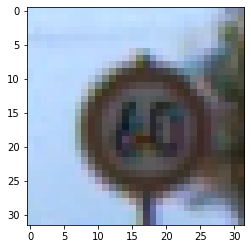

In [ ]:
#sample data 
index = np.random.randint(1,len(X_train))
plt.imshow(X_train[index])
print("image label = {}".format(y_train[index]))

##Image Pre-processing

1. **Converting to Grayscale** - Colour is not important of the roadsigns, the edges and shapes are the important part so we are converting into grayscale for better identification and computation.

2. **Histogram Equalization** - To standardize the lighting conditions.

3. **Normalization** - Normalize the pixel value between 0 and 1.

In [ ]:
#shuffle the data - To avoid learning the order of data
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train,y_train)

In [ ]:
def preprocessing(img):
  #convert to grayscale
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

  #Applying histogram equalization
  img = cv2.equalizeHist(img)
  
  #Normalization
  img = img/255

  return img

In [ ]:
X_train_processed = np.array(list (map(preprocessing,X_train)))
X_validation_processed = np.array(list (map(preprocessing,X_validation)))
X_test_processed = np.array(list (map(preprocessing,X_test)))

In [ ]:
X_train_processed = X_train_processed.reshape(34799,32,32,1)
X_test_processed = X_test_processed.reshape(12630,32,32,1)
X_validation_processed = X_validation_processed.reshape(4410,32,32,1)

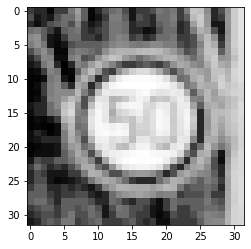

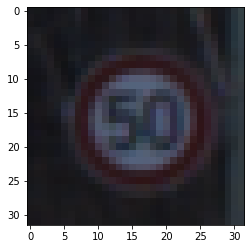

In [ ]:
#sample data image
ind = random.randint(1,len(X_train))
plt.imshow(X_train_processed[ind].squeeze(),cmap='gray')
plt.figure()
plt.imshow(X_train[ind].squeeze())

##CNN Model


In [ ]:
model = Sequential()
# add the convolutional layer
# filters, size of filters, activation_function, input_shape
model.add(Conv2D(32,(5,5),activation='relu',input_shape=(32,32,1)))

# Pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))

# Dropout layer
model.add(Dropout(0.25))

# Add another convolutional layer
model.add(Conv2D(64,(5,5),activation='relu'))

# Pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten the image to 1D array
model.add(Flatten())

# Dense layer: amount of nodes, activation
model.add(Dense(256,activation='relu'))

# Dropout layer - 0.5 drop out rate
model.add(Dropout(0.5))

# Output layer 
model.add(Dense(43,activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)              

In [ ]:
#Model compilation
model.compile(Adam(lr=0.0001),loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_processed,
                    y_train,
                    batch_size=500,
                    epochs=50,
                    verbose=1,
                    validation_data=(X_validation_processed,y_validation))

Train on 34799 samples, validate on 4410 samples
Epoch 1/50
34799/34799 [==============================] - 8s 244us/step - loss: 3.5423 - accuracy: 0.0635 - val_loss: 3.4688 - val_accuracy: 0.1200
Epoch 2/50
34799/34799 [==============================] - 2s 62us/step - loss: 3.2660 - accuracy: 0.1561 - val_loss: 3.0474 - val_accuracy: 0.3166
Epoch 3/50
34799/34799 [==============================] - 2s 62us/step - loss: 2.7293 - accuracy: 0.3099 - val_loss: 2.4168 - val_accuracy: 0.4222
Epoch 4/50
34799/34799 [==============================] - 2s 61us/step - loss: 2.2319 - accuracy: 0.4142 - val_loss: 1.9566 - val_accuracy: 0.5066
Epoch 5/50
34799/34799 [==============================] - 2s 61us/step - loss: 1.8878 - accuracy: 0.4809 - val_loss: 1.6388 - val_accuracy: 0.5680
Epoch 6/50
34799/34799 [==============================] - 2s 63us/step - loss: 1.6440 - accuracy: 0.5326 - val_loss: 1.3907 - val_accuracy: 0.6306
Epoch 7/50
34799/34799 [==============================] - 2s 62us/st

##Evaluate Performance of the Model

In [ ]:
score = model.evaluate(X_test_processed,y_test)
print('Test Accuracy',score[1])

12630/12630 [==============================] - 1s 105us/step
Test Accuracy 0.9128265976905823


In [ ]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

Text(0.5, 0, 'epochs')

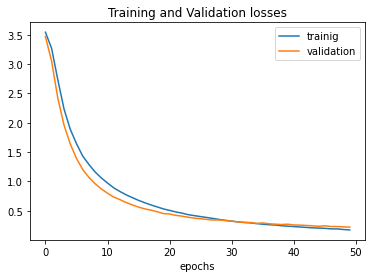

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['trainig','validation'])
plt.title('Training and Validation losses')
plt.xlabel('epochs')


Text(0.5, 0, 'epochs')

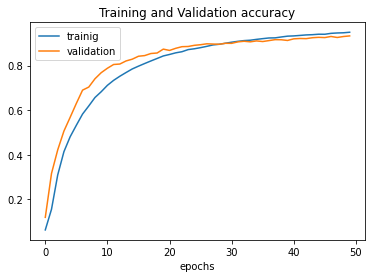

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['trainig','validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epochs')


In [ ]:
prediction = model.predict_classes(X_test_processed)
y_true_label = y_test

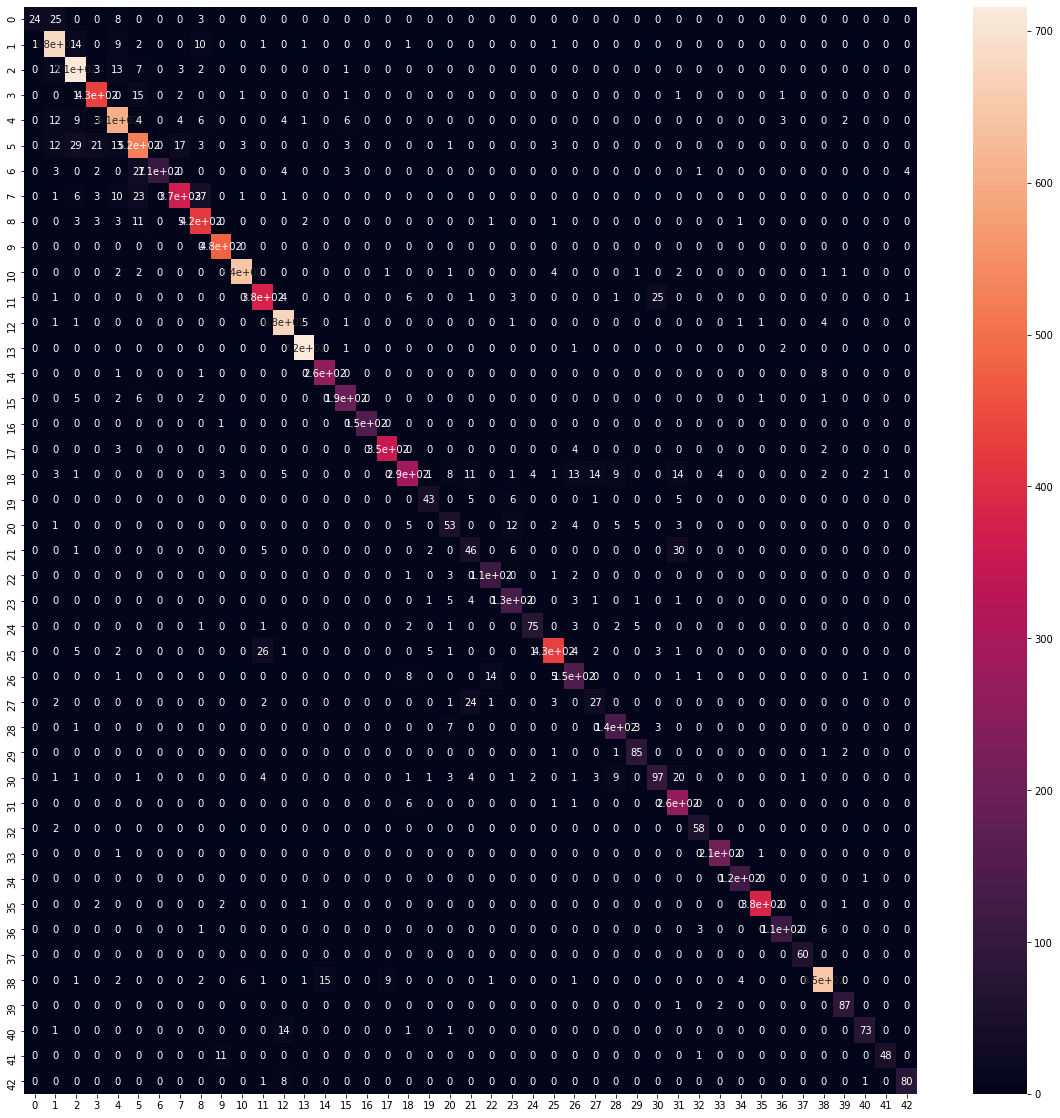

In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_true_label,prediction)

plt.figure(figsize=(20,20))
sns.heatmap(matrix,annot=True)

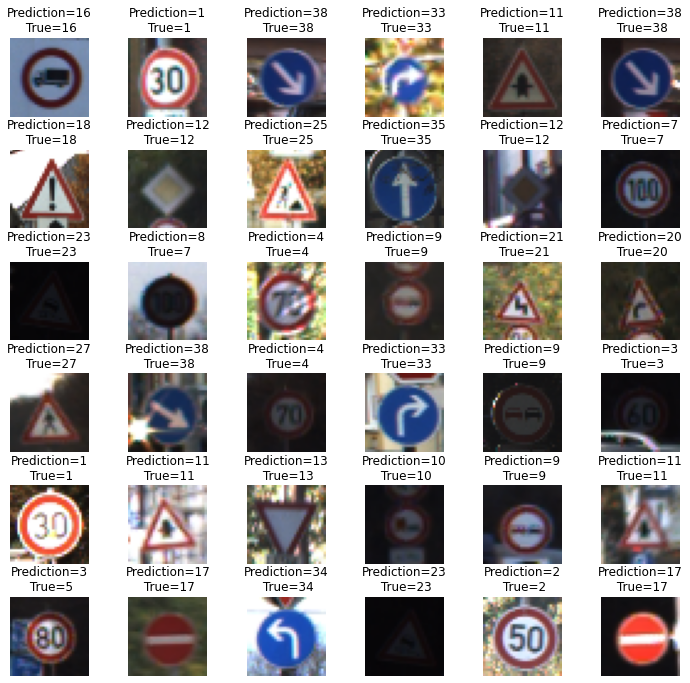

In [ ]:
length = 6
width = 6
fig , axes = plt.subplots(length,width,figsize=(12,12))
axes = axes.ravel()
for i in range(length*width):
  axes[i].imshow(X_test[i])
  axes[i].set_title('Prediction={}\n True={}'.
                    format(prediction[i],y_true_label[i]))
  axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

In [ ]:
model.save('my_model.ipynb')